# Scale Free Network simulations

In [289]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import EoN
import networkx as nx
import pandas as pd
import scipy.interpolate


N = 10**4
G = nx.barabasi_albert_graph(N, 4)
tmax = 200
simulationRuns = 10
tau = 0.025     #transmission rate
gamma = 0.1     #recovery rate
rho = 0.005     #random fraction initially infected
step = 0.1      #step size

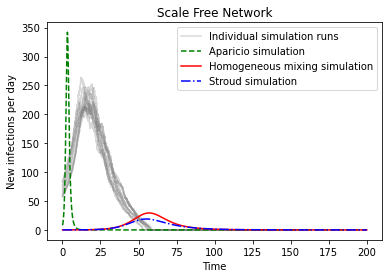

<Figure size 432x288 with 0 Axes>

In [292]:
xx = np.arange(0, tmax, step)
yy = np.arange(0, tmax, step)

k = 1000
for counter in range(simulationRuns):
    t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho = rho, tmax = tmax)
    incidence = np.empty([S.size])
    x=0
    while ((x+k) <= (S.size)-1):
        incidence[x] = -(S[x+k]-S[x])/(t[x+k]-t[x])
        x = x + 1
    if counter == 0:
        plt.plot(t, incidence, color = 'gray', alpha = 0.3, label = 'Individual simulation runs')
    plt.plot(t, incidence, color = 'gray', alpha = 0.3)

df1 = pd.read_csv('Sources/Aparicio_ScaleFreS.csv')
df1 = df1.loc[:, '{#status->#S}']
inc1 = - df1.diff()*N
inc1 = inc1[:2000]

df2 = pd.read_csv('Sources/Stroud_HMS.csv')
df2 = df2.loc[:, '{#status->#S}']
inc2 = - df2.diff()*N
inc2 = inc2[:2000]

df3 = pd.read_csv('Sources/Stroud_ScaleS.csv')
df3 = df3.loc[:, '{#status->#S}']
inc3 = - df3.diff()*N
inc3 = inc3[:2000]

plt.plot(xx, inc1, '--', label = 'Aparicio simulation', color = 'green')
plt.plot(xx, inc2, label = 'Homogeneous mixing simulation', color = 'red')
plt.plot(xx, inc3, '-.', label = 'Stroud simulation', color = 'blue')

plt.xlabel('Time')
plt.ylabel('New infections per day')
plt.title('Scale Free Network')
plt.legend()
plt.show()
plt.savefig('Plot/Scale_Free_network.png')